# Tensorflow V2로 학습한 모델을 SageMaker로 배포하기

본 노트북에서는 학습된 모델을 SageMaker endpoint로 배포하는 프로세스를 살펴봅니다. [첫번째 노트북](1.mnist_train.ipynb)에서 매직명령어 %store% 로 저장했던 `model_data`의 모델 아티팩트를 로드하여 사용합니다. (만약 이전에 생성한 모델 아티팩트가 없다면 공개 S3 버킷에서 해당 파일을 다운로드하게 됩니다.)

In [2]:
import sagemaker 
sagemaker.__version__

'2.45.0'

In [6]:
# setups

import os
import json

import sagemaker
from sagemaker.tensorflow import TensorFlowModel
from sagemaker import get_execution_role, Session
import boto3

# Get global config
with open('code/config.json', 'r') as f:
    CONFIG=json.load(f)

sess = Session()
role = get_execution_role()

%store -r tf_mnist_model_data


# store -r 시도 후 모델이 없는 경우 publc s3 bucket에서 다운로드
try: 
    tf_mnist_model_data
except NameError:
    import json
    # copy a pretrained model from a public public to your default bucket
    s3 = boto3.client('s3')
    bucket = CONFIG['public_bucket']
    key = 'datasets/image/MNIST/model/tensorflow-training-2020-11-20-23-57-13-077/model.tar.gz'
    s3.download_file(bucket, key, 'model.tar.gz')
    tf_mnist_model_data = sess.upload_data(
        path='model.tar.gz', bucket=sess.default_bucket(), key_prefix='model/tensorflow')
    os.remove('model.tar.gz')



no stored variable or alias tf_mnist_model_data


In [7]:
print(tf_mnist_model_data)

s3://sagemaker-us-east-1-308961792850/model/tensorflow/model.tar.gz


## TensorFlow Model Object

SageMaker에서 제공하는 `TensorFlowModel` 클래스는 여러분의 모델 아티팩트를 이용하여 추론을 실행하는 환경을 정의하도록 해 줍니다. 이는 [첫번째 노트북](1.mnist_train.ipynb)에서 `TensorFlow` estimator를 정의했던 것과 유사한 방식으로, 학습된 모델을 SageMaker에서 호스팅하도록 도커 이미지를 정의하는 하이레벨 API입니다. 

해당 API를 통해 모델을 추론할 환경을 설정하고 나면 SageMaker에서 관리하는 EC2 인스턴스에서 SageMaker Endpoint 형태로 실행할 수 있습니다. SageMaker Endpoint는 학습된 모델을 RESTful API를 통해 추론하도록 하는 컨테이너기반 환경입니다. 

`TensorFlowModel` 클래스를 초기화할 때 사용되는 파라미터들은 다음과 같습니다.
- role: AWS 리소스 사용을 위한 An IAM 역할(role) 
- model_data: 압축된 모델 아티팩트가 있는 S3 bucket URI. local mode로 실행시에는 로컬 파일경로 사용가능함
- framework_version: 사용하 프레임워크의 버전
- py_version: 파이썬 버전

In [8]:

model = TensorFlowModel(
    role=role,
    model_data=tf_mnist_model_data,
    framework_version='2.3.1'
)


## 추론 컨테이너 실행

`TensorFlowModel` 클래스가 초기화되고 나면 `deploy`메소드를 이용하여 호스팅용 컨테이너를 실행할 수 있습니다.  

`deploy`메소드 실행시 사용되는 파라미터들은 다음과 같습니다.
- initial_instance_count: 호스팅 서비스에 사용할 SageMaker 인스턴스의 숫자 
- instance_type: 호스팅 서비스를 실행할 SageMaker 인스턴스 타입. 이 값을 `local` 로 선택하면 로컬 인스턴스(SageMaker Jupyter notebook)에 호스팅 컨테이너가 실행됩니다. local mode는 주로 디버깅 단계에서 사용하게 됩니다. 

<span style="color:red"> 주의 : SageMaker Studio 환경에서는 local mode 가 지원되지 않습니다. </span>

In [9]:
# from sagemaker.serializers import JSONSerializer
# from sagemaker.deserializers import JSONDeserializer

instance_type='ml.c4.xlarge'

predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    )

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---------------!

## SageMaker endpoint를 이용한 예측 실행

`model.deploy(...)`에 의해 리턴된 `Predictor` 인스턴스를 이용하여 예측 요청을 endpoint에 보낼 수 있습니다. 이 경우 모델은 정규화 된 배치 이미지를 받습니다.


In [10]:
# use some dummy inputs
import numpy as np

dummy_inputs = {
    'instances': np.random.rand(4, 28, 28, 1)
}

res = predictor.predict(dummy_inputs)
print(res)

{'predictions': [[-0.273208916, -1.84885871, 3.57142687, 2.07275, -3.12278843, 4.66189718, 1.67159903, -1.03760433, -0.651746273, -0.911848605], [-0.498024851, -1.53155744, 2.26986909, 1.57189918, -3.48851228, 5.39972925, -0.367087483, -1.20520651, 0.416271985, -1.93182898], [0.621301889, -1.80672109, 3.56093812, 2.74319458, -1.42010963, 3.7041657, 0.29974851, -0.479572117, -0.61971, -2.08280349], [-1.13145185, -1.91006196, 3.93134689, 2.65630388, -3.193367, 3.8307631, 0.0389500149, 0.0279379766, -0.107712097, -2.26930761]]}


입출력 데이터 포맷이 [TensorFlow Serving REST API](https://www.tensorflow.org/tfx/serving/api_rest)의 `Predict`에서 정의된 request, respoinst 포맷과 일치하는 지 확인합니다. 

예를 들어 본 코드에서 `dummy_inputs`은 `instances`를 키로 하여 배열의 형태로 전달하고 있습니다. 또한 입력데이터는 batch dimension을 포함한 4차원 배열로 구성되어 있습니다.

In [15]:
# # Uncomment the following lines to see an example that cannot be processed by the endpoint

# dummy_data = {
#    'instances': np.random.rand(28, 28, 1).tolist()
# }
# print(predictor.predict(dummy_data))

이제 실제 MNIST 테스트 데이터로 엔드포인트를 호출해 봅니다. 여기서는 MNIST 데이터를 다운로드하고 normalize하기 위해 `code.utils` 의 헬퍼함수를 사용하였습니다.

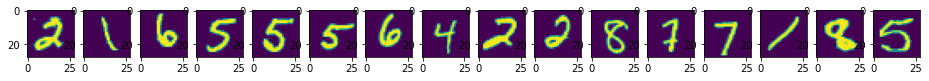

In [16]:
from utils.mnist import mnist_to_numpy, normalize
import random
import matplotlib.pyplot as plt
%matplotlib inline

data_dir = '/tmp/data'
X, _ = mnist_to_numpy(data_dir, train=False)

# randomly sample 16 images to inspect
mask = random.sample(range(X.shape[0]), 16)
samples = X[mask]

# plot the images 
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(16, 1))

for i, splt in enumerate(axs):
    splt.imshow(samples[i])

모델이 nomalized 된 입력을 받게 되어있으므로 normalize 처리 후 엔디포인트를 호출합니다. 

In [17]:
samples = normalize(samples, axis=(1, 2))
predictions = predictor.predict(
    np.expand_dims(samples, 3) # add channel dim
)['predictions'] 

# softmax to logit
predictions = np.array(predictions, dtype=np.float32)
predictions = np.argmax(predictions, axis=1)


In [18]:
print("Predictions: ", predictions.tolist())

Predictions:  [2, 1, 6, 5, 5, 5, 6, 4, 2, 2, 8, 7, 7, 1, 8, 5]


## (Optional) 새로운 환경에서 추론 endpoint 호출

SageMaker는 배포된 endpoint를 호출하는 `ReatTimePredictor` 클래스를 제공합니다. 이는 별도의 새로운 환경에서 endpoint를 호출하는 방식을 예제로 보여줍니다.

먼저 생성된 endpoint의 이름을 기억합니다. 여기서는 앞서 생성한 predictor객체로부터 가져오겠습니다.

In [21]:
my_endpoint = predictor.endpoint_name
print(my_endpoint)

tensorflow-inference-2021-07-17-06-23-20-924


`endpoint_name`을 이용하여 `ReatTimePredictor` 오브젝트를 생성합니다. 

In [54]:
from sagemaker.predictor import  Predictor 
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

my_predictor = Predictor(endpoint_name=my_endpoint, 
                         sagemaker_session=sess, 
                         serializer=JSONSerializer(), 
                         deserializer=JSONDeserializer())

이제 predict 함수를 이용하여 추론을 요청할 수 있습니다. 이전 코드에서 사용했던 dummy_inputs을 테스트용 데이터로 이용하겠습니다.

In [100]:
dummy_inputs = {
    'instances': np.random.rand(4, 28, 28, 1)
}

my_predictor.predict(dummy_inputs)

{'predictions': [[-0.669917285,
   -1.96295488,
   2.45045376,
   2.39978123,
   -2.82160378,
   5.57341433,
   -0.798523903,
   -0.685512,
   -0.388749391,
   -1.4701122],
  [0.970101774,
   -2.92070675,
   2.45413542,
   3.16425562,
   -4.32433176,
   5.33695793,
   -0.800671875,
   -0.647063851,
   -0.807406425,
   -1.72747409],
  [-0.624027431,
   -0.81976074,
   1.65127921,
   1.2912401,
   -2.38204,
   4.14326954,
   0.254346192,
   0.657923818,
   -1.13853729,
   -0.97038573],
  [0.457151264,
   -2.37329817,
   2.87692165,
   2.82102227,
   -3.09995866,
   3.78902507,
   0.37899068,
   -0.33909753,
   -0.530351341,
   -1.86200893]]}

추론 실행을 위해 boto3 SDK를 이용할 수도 있습니다. 아래 코드를 참조합니다.

In [99]:
import boto3
sm_runtime = boto3.Session().client(service_name='sagemaker-runtime',region_name=sess.boto_region_name)

response = sm_runtime.invoke_endpoint(EndpointName=my_endpoint, 
                                      ContentType='application/json', 
                                      Accept='application/json',
                                      Body=json.dumps(dummy_inputs))

json.loads(response.get('Body').read().decode())

{'predictions': [[-0.655917227,
   -2.23962426,
   3.59197783,
   1.76635075,
   -3.34997892,
   5.15842819,
   0.742403328,
   -0.761104465,
   -0.740676284,
   -1.05630982],
  [0.223428115,
   -0.796258092,
   3.37947655,
   1.81045294,
   -4.2889204,
   4.25302458,
   -0.0707127675,
   -0.773146152,
   -0.168461606,
   -2.64786577],
  [-0.0286980402,
   -2.4657743,
   3.92348313,
   3.80187416,
   -2.2851882,
   4.28839159,
   -0.687379599,
   -0.659042239,
   -0.922584295,
   -1.58239615],
  [-1.67189,
   -0.988356113,
   2.77206588,
   0.80530715,
   -2.5047431,
   4.33526564,
   -1.15979326,
   1.05716884,
   0.118411146,
   -2.45529652]]}

## 리소스 삭제

endpoint의 사용이 끝나면 추가과금을 막기 위해 endpoint를 삭제합니다. 로컬을 사용한 경우 포트 8080에서 바운드 된 Docker 컨테이너 (들어오는 요청을 수신하는 포트)를 수동으로 삭제해야합니다.

In [49]:
import os

if not local_mode:
    predictor.delete_endpoint()
else:
    os.system("docker container ls | grep 8080 | awk '{print $1}' | xargs docker container rm -f")